# Machine Learning (ML) Exploratory Data Analysis

The intent of this notebook is three-fold:
* First an Exploratory Data Analysis (EDA) is conducted to visualise the distribution of the tabular dataset built on a S2 image with the `1.1_label_generator.ipynb` Notebook
* Next, review the correlation of some of the S2 spectral bands in the task of water classification. 
* Finally, feature engineering and outlier detection for improving the dataset 

## 1. Import Libraries

In [2]:
import os
import sys
import csv
import glob
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

# Machine Learning imports
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

# Ignore a few warnings for cleaner output
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables

In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [24]:
# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# columns not needed for training
colsToDrop = ['Index', 'long', 'lat', 'LUC']

# columns used as features during training
v_names = ['blue','green','red','nir','swir16','swir22','ndvi','ndwi1','ndwi2','water','coastal']

Here we create an output directory to store any artifacts out of our EDA visualizations.

In [25]:
os.makedirs('output', exist_ok=True)

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:
  - Read in data to a Dataframe
  - Drop unnecessary columns
  - Split into Xs and Ys

In [26]:
%%time
df_pandas = pd.read_csv('df_extractedpixels.csv', usecols=lambda column: column not in colsToDrop)
df_pandas

CPU times: user 5.99 ms, sys: 84 µs, total: 6.08 ms
Wall time: 4.99 ms


,coastal,blue,green,red,nir,swir16,swir22,ndvi,ndwi1,ndwi2,water
0,318,363,542,754,1115,2141,2069,1931,-3151,-2996,0.0
1,365,448,552,738,1062,2328,2275,1800,-3734,-3635,0.0
2,833,432,645,872,1534,2059,1696,2751,-1461,-501,0.0
3,308,312,507,533,1952,1694,977,5710,707,3328,0.0
4,261,394,650,1044,1454,2629,2482,1641,-2877,-2611,0.0
...,...,...,...,...,...,...,...,...,...,...,...
395,156,1,78,29,61,622,431,3555,-8213,-7520,0.0
396,241,260,574,710,2927,2009,1191,6095,1859,4215,0.0
397,416,462,640,891,1265,2100,2119,1734,-2481,-2523,0.0
398,91,246,480,443,2766,1426,788,7239,3196,5565,0.0


## 4. Data Cleaning

In this section we will start to inspect and understand the nature of our dataset.

The simplest first step when we have a DataFrame dataset is to inspect the data types, columns, attributes, and shape of our dataset.

In [27]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coastal  400 non-null    int64  
 1   blue     400 non-null    int64  
 2   green    400 non-null    int64  
 3   red      400 non-null    int64  
 4   nir      400 non-null    int64  
 5   swir16   400 non-null    int64  
 6   swir22   400 non-null    int64  
 7   ndvi     400 non-null    int64  
 8   ndwi1    400 non-null    int64  
 9   ndwi2    400 non-null    int64  
 10  water    400 non-null    float64
dtypes: float64(1), int64(10)
memory usage: 34.5 KB


Pandas provides an excellent function to inspect the contents of our dataframes in a more concise way. Note the number of observations per feature, and the minimum and maximum values per MODIS band.

In [28]:
df_pandas.describe().T

,count,mean,std,min,25%,50%,75%,max
coastal,400.0,356.2750,356.209246,1.0,182.75,285.5,404.75,3580.0
blue,400.0,435.5100,431.492043,1.0,232.00,352.0,524.25,3776.0
green,400.0,657.9050,465.474378,40.0,430.00,567.0,752.50,4288.0
red,400.0,759.8225,508.406924,26.0,423.75,671.5,992.25,4484.0
nir,400.0,1942.1825,720.763292,1.0,1555.00,1957.5,2329.50,4760.0
swir16,400.0,1908.5525,681.693753,74.0,1469.50,1914.5,2325.75,4973.0
swir22,400.0,1432.6025,677.951492,78.0,923.50,1361.5,1855.25,4286.0
ndvi,400.0,4245.1575,2698.450366,-9869.0,2165.50,4406.0,6290.25,9062.0
ndwi1,400.0,-63.1525,2422.323029,-9885.0,-1708.75,-55.0,1560.50,8487.0
ndwi2,400.0,1423.6125,3091.823731,-9897.0,-642.25,1616.0,3744.25,8972.0


Check if our dataset contains any no-data values

In [29]:
df_pandas[df_pandas.isnull().any(axis=1)]

,coastal,blue,green,red,nir,swir16,swir22,ndvi,ndwi1,ndwi2,water


Generally speaking, we can remove rows with no-data values. If we know no-data values belong to a specific group, we might be able to convert it to the appropiate value. 

Once we have dealt with our no-data values, we can go ahead and visualize some of the data to understand its structure and find any patterns.

In [30]:
# Get a sample so we can speed up expensive visualizations
sampledDf = df_pandas.sample(frac=0.5)
sampledDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 136 to 245
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coastal  200 non-null    int64  
 1   blue     200 non-null    int64  
 2   green    200 non-null    int64  
 3   red      200 non-null    int64  
 4   nir      200 non-null    int64  
 5   swir16   200 non-null    int64  
 6   swir22   200 non-null    int64  
 7   ndvi     200 non-null    int64  
 8   ndwi1    200 non-null    int64  
 9   ndwi2    200 non-null    int64  
 10  water    200 non-null    float64
dtypes: float64(1), int64(10)
memory usage: 18.8 KB


In [31]:
df_pandas.sample(n=5)

,coastal,blue,green,red,nir,swir16,swir22,ndvi,ndwi1,ndwi2,water
225,601,770,890,1104,1312,2021,1997,860,-2127,-2070,0.0
1,365,448,552,738,1062,2328,2275,1800,-3734,-3635,0.0
198,180,209,501,470,2622,1723,1029,6959,2069,4363,0.0
81,394,389,601,614,2167,2387,1596,5584,-483,1517,0.0
391,279,314,425,124,67,75,78,-2984,-563,-758,1.0


## 5. Exploratory Data Analysis

### 5.1 Correlation plots with water points as orange

This step might take up to 15 minutes depending on hardware. Here we perform a correlation of bands and water/no-water pixels using the seaborn library. This first correlation step can help us find interesting features in our data by looking directly into relationships between our feature columns and our labels. Here we plot multiple pairwise bivariate distributions of the dataset where the diagonal plots are the univariate plots, and this displays the relationship for the (n, 2) combination of variables in a DataFrame as a matrix of plots.

In [ ]:
sns.set()
sns.pairplot(df_pandas, hue=LABEL_NAME, kind='reg')
plt.savefig('output/img_test.png')

### 5.2 Distribution for each channel

Another good practice is to understand the distribution of values for each column feature. This will show you where most of your data lives for each feature in the dataset, including the distribution of training labels.

array([[<Axes: title={'center': 'B04'}>, <Axes: title={'center': 'B02'}>],
       [<Axes: title={'center': 'SCL'}>, <Axes: title={'center': 'B03'}>],
       [<Axes: title={'center': 'B08'}>, <Axes: >]], dtype=object)

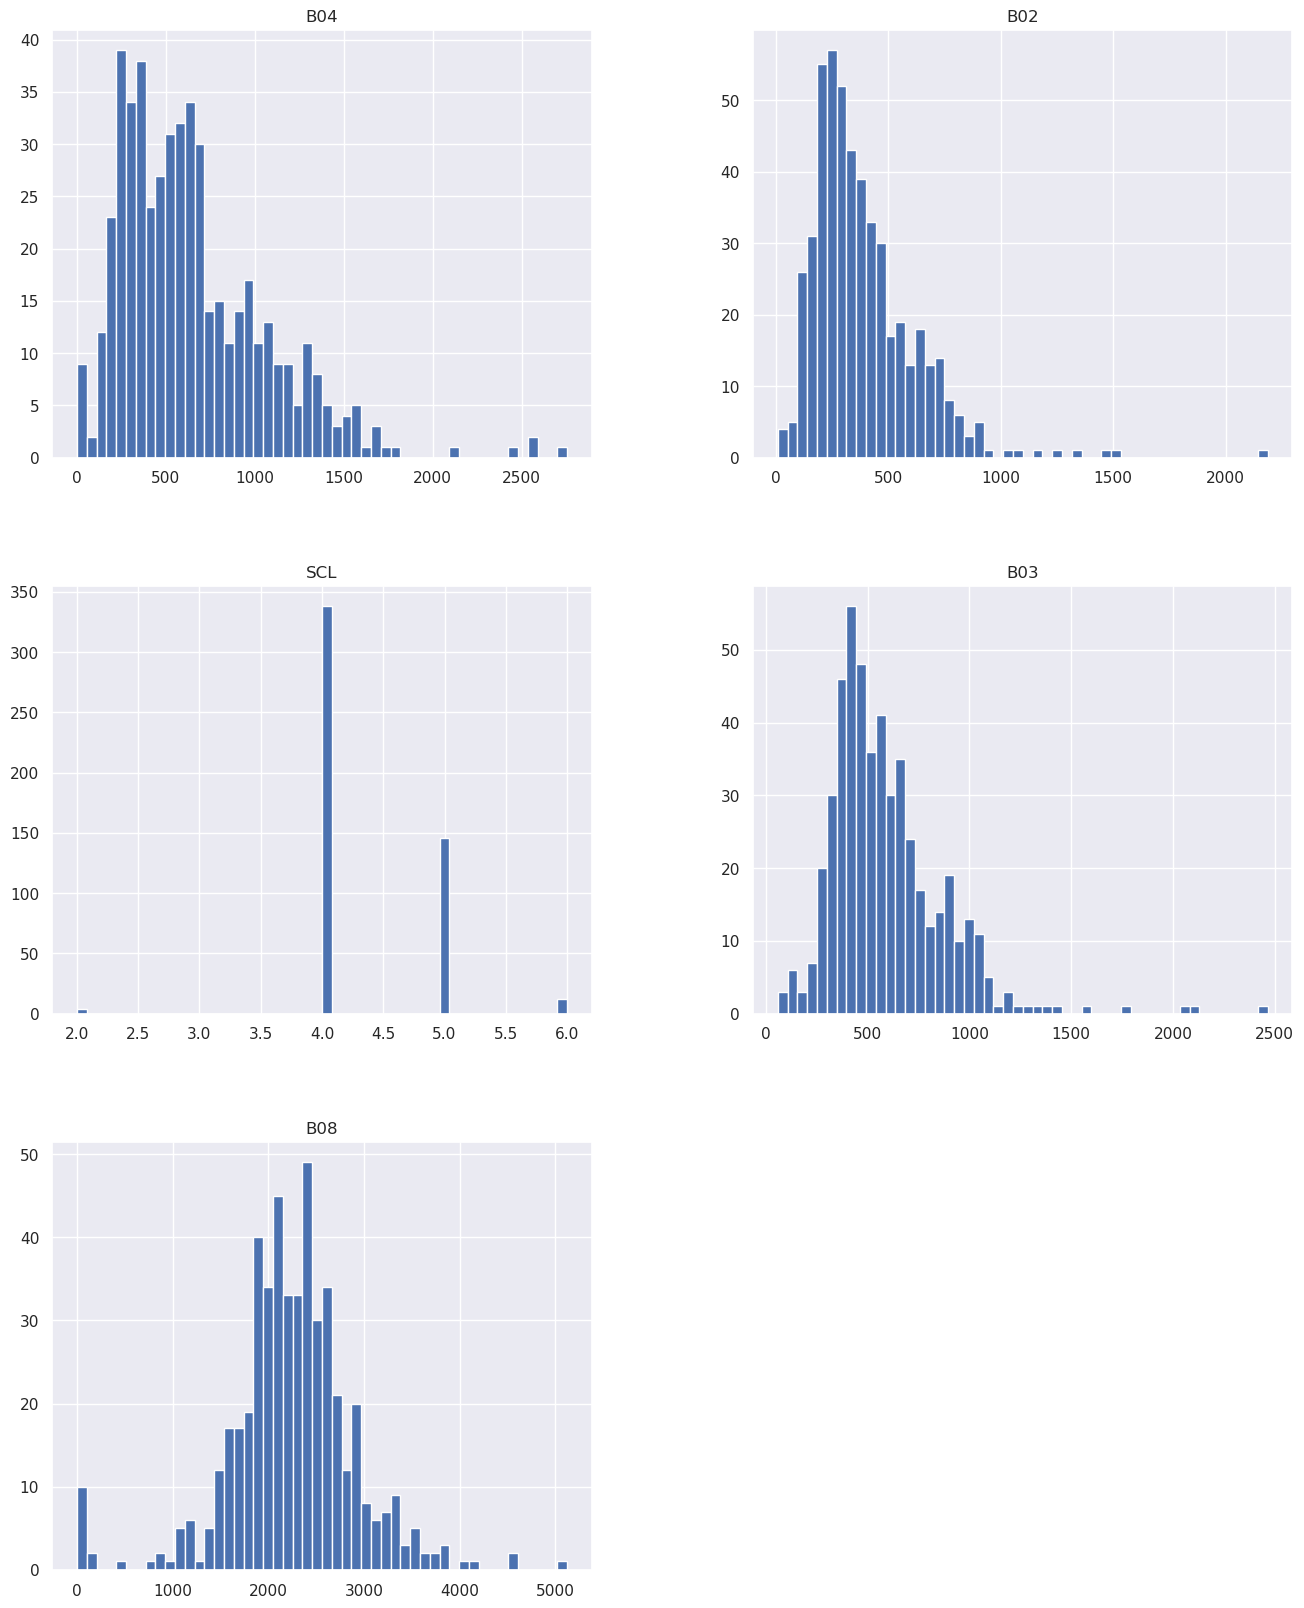

In [11]:
df_pandas.hist(figsize=(16, 20), bins=50)

### 5.3 Correlation calculations

Here we can do a more statistical approach to correlation using pandas corr() function.

In [12]:
# correlation with dataset - target value
corr = df_pandas.corr()['SCL']
corr.to_csv('output/correlation.csv')
corr

B04    0.430434
B02    0.407676
SCL    1.000000
B03    0.345054
B08   -0.356939
Name: SCL, dtype: float64

In [13]:
# full correlation table
df_pandas.corr().style.background_gradient(cmap='viridis')

,B04,B02,SCL,B03,B08
B04,1.000000,0.942121,0.430434,0.952648,0.149288
B02,0.942121,1.000000,0.407676,0.964846,0.154918
SCL,0.430434,0.407676,1.000000,0.345054,-0.356939
B03,0.952648,0.964846,0.345054,1.000000,0.308575
B08,0.149288,0.154918,-0.356939,0.308575,1.000000


## 5.4 Another Look at Distributions

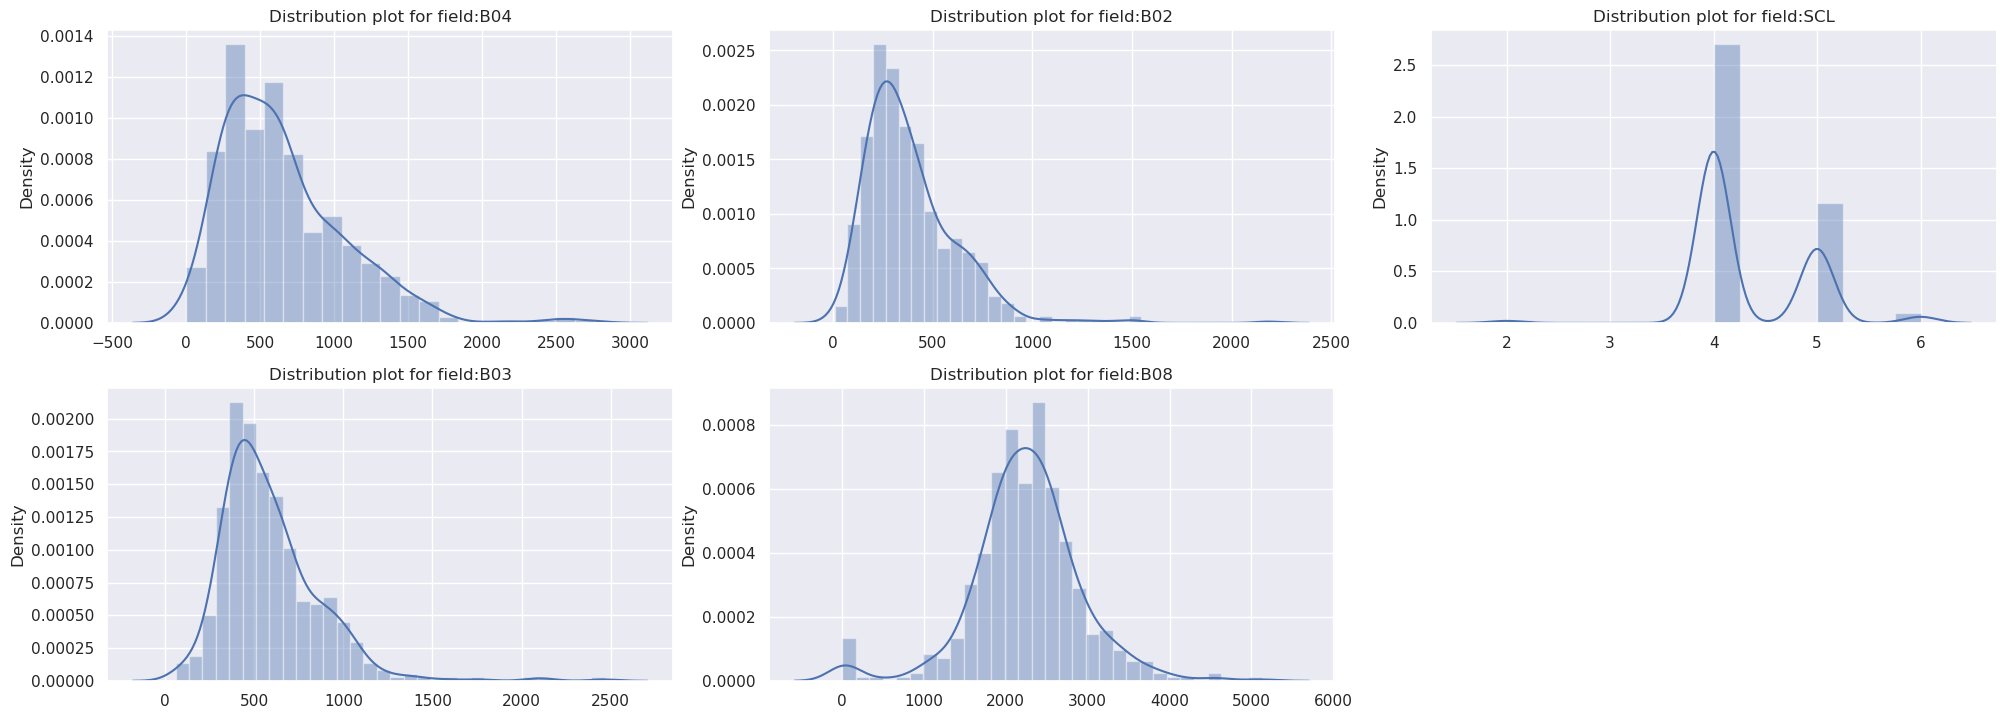

In [14]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(df_pandas.select_dtypes(include='number').columns):
    plt.subplot(4,3,i+1)
    sns.distplot(df_pandas[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('output/output_dist_modis_water.png')

We can also target specifically the distribution of specific features when related to the corresponding label.

In [16]:
df_pandas.hist(column='B08', by='SCL', bins=30, grid=True, figsize=(8, 10), layout=(1, 1), zorder=2, rwidth=0.9, sharex=False)
# plt.savefig('output/b01_dist.png')

ValueError: Layout of 1x1 must be larger than required size 4

<Figure size 800x1000 with 0 Axes>

In [ ]:
df_pandas.hist(column='sur_refl_b02_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
plt.savefig('output/b02_dist.png')

In [ ]:
df_pandas.hist(column='sur_refl_b03_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
plt.savefig('output/b03_dist.png')

In [ ]:
df_pandas.hist(column='sur_refl_b04_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
plt.savefig('output/b04_dist.png')

In [ ]:
df_pandas.hist(column='sur_refl_b05_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b05_dist.png'.format(TILE))

In [ ]:
df_pandas.hist(column='sur_refl_b06_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b06_dist.png'.format(TILE))

In [ ]:
df_pandas.hist(column='sur_refl_b07_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b07_dist.png'.format(TILE))

In [ ]:
df_pandas.hist(column='ndvi', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=True)

In [ ]:
df_pandas.hist(column='ndwi1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)

In [ ]:
df_pandas.hist(column='ndwi2', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)

### 5.5 Outlier Detection¶

Finding outliers is important to understand those corner cases where our models might not perform as expected, or where we might need additional training data from. There are several ways of finding outlier values, but we will concentrate on Tukey IQR for this example.

Tukey IQR rule says that the outliers are values more than 1.5 times the interquartile range from the quartiles — either below Q1 − 1.5 IQR, or above Q3 + 1.5IQR. Thus we can simply calculate outliers per column feature by taking the necessary percentiles.

In [ ]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices,outlier_values

For example, outliers from ndwi2 are listed below:

In [ ]:
tukey_indices,tukey_values = find_outliers_tukey(df_pandas['ndwi2'])
np.sort(tukey_values)

## 5.6 Feature Engineering, Creating New Features

There are cases were our features might not be enough for our model. We might have a small number of features, or a set of features that might not be representative enough. One general approach to solve this is to use feature engineering techniques to increase and/or improve our dataset representativeness.

For our water classification example, we do not need any feature engineering techniques, since we are able to perform accurate detections by simply calculating several indices and using the original optical bands.

However, this might be necessary in other problems where your data by itself might not provide enough representativeness.


In [ ]:
def add_interactions(df):
    combos = list(combinations(list(df.columns),2))
    colnames = list(df.columns) + ['_'.join(x) for  x in combos]
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis= 1)
    
    return df

In this function we simply produce combinataions of each band that increases out feature space from 10 to 65. For an algorithm like a random forest where decisions are being made, this could provide a substantial improvement. Algorithms like convolutional neural networks might not need these since they can extract patterns directly out of the data.

In [ ]:
df_pandas_expanded = add_interactions(df_pandas)
df_pandas_expanded.head()

## 5.7 Dimesionality reduction using PCA

PCA is a tecnique that transforms a dataset of many features into pricipal components that summarize the variance that underlies the data. This can also be used to extract the principal components from each feature so they can be used in training.

In [ ]:
pca = PCA(n_components=66)
X_pca = pd.DataFrame(pca.fit_transform(df_pandas_expanded))
X_pca.head()

## Closing Thoughts

We have:
- Downloaded a MODIS based dataset for training, which we will use in the next portion of this training
- Performed EDA on the provided dataset and understand some of the characteristics of the given dataset
- Introduced several feature engineering techniques for dealing with no-data and to increase training data representativeness
- Provided additional tools to deal with the data and drive physical conclusions before going into training our machine learning model